**Problem Statement** : In the realm of E-Commerce, demand forecasting plays a pivotal role in ensuring business success. This project aims to develop a demand forecasting model in an E-commerce business that predicts future product demand leveraging time series analysis and multivariate regression based on historical sales data, along with Google Analytics KPIs such as Google clicks and Facebook impressions, which are valuable indicators of customer interest.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# **Data merging and Exploratory data analysis**




In [3]:
# Loading datasets
sales_data = pd.read_excel('ProductA.xlsx')
google_clicks = pd.read_excel('ProductA_google_clicks.xlsx')
facebook_impressions = pd.read_excel('ProductA_fb_impressions.xlsx')

# Converting date fields to datetime
sales_data['Day Index'] = pd.to_datetime(sales_data['Day Index'])
google_clicks['Day Index'] = pd.to_datetime(google_clicks['Day Index'])
facebook_impressions['Day Index'] = pd.to_datetime(facebook_impressions['Day Index'])

# Merging datasets on 'Date'
merged_data = sales_data.merge(google_clicks, on='Day Index', how='left')
merged_data = merged_data.merge(facebook_impressions, on='Day Index', how='left')

# Displaying the merged dataset
print(merged_data)

     Day Index  Quantity  Clicks  Impressions
0   2021-12-01        14     445          620
1   2021-12-02        10     433          890
2   2021-12-03        13     424          851
3   2021-12-04        22     427          881
4   2021-12-05        33     451          678
..         ...       ...     ...          ...
207 2022-06-26        13     114         1218
208 2022-06-27        16     106         1311
209 2022-06-28        13     109          885
210 2022-06-29        16      60         1000
211 2022-06-30         8      65          875

[212 rows x 4 columns]


In [4]:
merged_data.shape

(212, 4)

In [5]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day Index    212 non-null    datetime64[ns]
 1   Quantity     212 non-null    int64         
 2   Clicks       212 non-null    int64         
 3   Impressions  212 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.8 KB


In [6]:
merged_data.describe()

,Day Index,Quantity,Clicks,Impressions
count,212,212.000000,212.00000,212.000000
mean,2022-03-16 12:00:00,17.542453,358.20283,1531.702830
min,2021-12-01 00:00:00,5.000000,60.00000,620.000000
25%,2022-01-22 18:00:00,13.750000,154.00000,1209.750000
50%,2022-03-16 12:00:00,17.000000,402.50000,1460.000000
75%,2022-05-08 06:00:00,21.000000,492.75000,1862.000000
max,2022-06-30 00:00:00,38.000000,726.00000,2707.000000
std,NaN,5.790423,164.52160,440.660783


In [7]:
# Checking for missing values
print("Missing values before handling:")
print(merged_data.isnull().sum())


Missing values before handling:
Day Index      0
Quantity       0
Clicks         0
Impressions    0
dtype: int64


**No missing value found**

In [8]:
#dropping duplicates if any
merged_data.drop_duplicates()

,Day Index,Quantity,Clicks,Impressions
0,2021-12-01,14,445,620
1,2021-12-02,10,433,890
2,2021-12-03,13,424,851
3,2021-12-04,22,427,881
4,2021-12-05,33,451,678
...,...,...,...,...
207,2022-06-26,13,114,1218
208,2022-06-27,16,106,1311
209,2022-06-28,13,109,885
210,2022-06-29,16,60,1000


**No duplicates found**

# **Outliers detection and imputation**

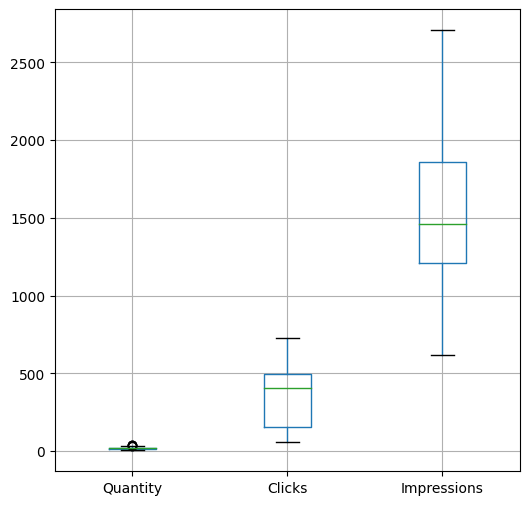

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
merged_data.boxplot()
plt.show()

**Outliers found in Quantity column**

In [10]:
#function to identify outliers
def identify_outliers_iqr(data):
  Q1 = data.quantile(0.25)
  Q3 = data.quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - (1.5 * IQR)
  upper_bound = Q3 + (1.5 * IQR)
  outliers = data[(data < lower_bound) | (data > upper_bound)]
  return outliers

sales_outliers_iqr = identify_outliers_iqr(merged_data['Quantity'])
google_clicks_outliers_iqr = identify_outliers_iqr(merged_data['Clicks'])
facebook_impressions_outliers_iqr = identify_outliers_iqr(merged_data['Impressions'])

print("Sales outliers:", len(sales_outliers_iqr))
print("Google Clicks outliers:", len(google_clicks_outliers_iqr))
print("Facebook Impressions outliers:", len(facebook_impressions_outliers_iqr))


Sales outliers: 5
Google Clicks outliers: 0
Facebook Impressions outliers: 0


In [11]:
print("Sales outliers:\n\n", sales_outliers_iqr)

Sales outliers:

 4      33
9      38
78     38
113    32
142    36
Name: Quantity, dtype: int64


In [12]:
data = merged_data.copy()
print(data)

     Day Index  Quantity  Clicks  Impressions
0   2021-12-01        14     445          620
1   2021-12-02        10     433          890
2   2021-12-03        13     424          851
3   2021-12-04        22     427          881
4   2021-12-05        33     451          678
..         ...       ...     ...          ...
207 2022-06-26        13     114         1218
208 2022-06-27        16     106         1311
209 2022-06-28        13     109          885
210 2022-06-29        16      60         1000
211 2022-06-30         8      65          875

[212 rows x 4 columns]


In [13]:
# Function to replace outliers with 95th percentile
def replace_outliers_with_percentile(data, percentile=95):
    threshold = data.quantile(percentile / 100)
    data_no_outliers = data.copy()
    data_no_outliers[data > threshold] = threshold
    return data_no_outliers

data['Quantity_no_outliers'] = replace_outliers_with_percentile(data['Quantity']).astype(int)
print(f"Sales outliers after replacement: {len(identify_outliers_iqr(data['Quantity_no_outliers']))}")
print(data.head())

Sales outliers after replacement: 0
   Day Index  Quantity  Clicks  Impressions  Quantity_no_outliers
0 2021-12-01        14     445          620                    14
1 2021-12-02        10     433          890                    10
2 2021-12-03        13     424          851                    13
3 2021-12-04        22     427          881                    22
4 2021-12-05        33     451          678                    27


**New_Quantity column contains the quantity values without outliers**

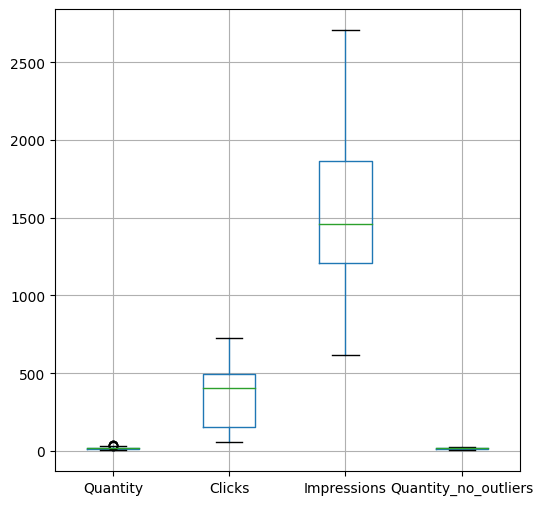

In [14]:
plt.figure(figsize=(6,6))
data.boxplot()
plt.show()

**The above boxplot shows that New_Quantity doesn't contain any values with outliers.**

# **Feature Engineering**

In [17]:
# Day of the month
data['Day of the Month'] = data['Day Index'].dt.day

# Extracting month and day of the week
data['month'] = data['Day Index'].dt.month_name()
data['day_of_week'] = data['Day Index'].dt.day_name()

# Creating binary columns for months
months = data['month'].unique()
for month in months:
    data[month] = (data['month'] == month).astype(int)

# Creating binary columns for days of the week
days_of_week = data['day_of_week'].unique()
for day in days_of_week:
    data[day] = (data['day_of_week'] == day).astype(int)

# Weekend feature
data['Is_Weekend'] = data['Day Index'].dt.dayofweek.isin([5, 6]).astype(int)

# Weekdays
data['Is_Weekday'] = 1 - data['Is_Weekend']

# Holiday feature
us_holidays = holidays.US()
data['Is_Holiday'] = data['Day Index'].apply(lambda x: 1 if x in us_holidays else 0)

# Week and Month Numeric value
data['day_of_week_num'] = data['Day Index'].dt.dayofweek
data['month_num'] = data['Day Index'].dt.month

print(data.head())

   Day Index  Quantity  Clicks  Impressions  Quantity_no_outliers  \
0 2021-12-01        14     445          620                    14   
1 2021-12-02        10     433          890                    10   
2 2021-12-03        13     424          851                    13   
3 2021-12-04        22     427          881                    22   
4 2021-12-05        33     451          678                    27   

   Day of the Month     month day_of_week  December  January  ...  Friday  \
0                 1  December   Wednesday         1        0  ...       0   
1                 2  December    Thursday         1        0  ...       0   
2                 3  December      Friday         1        0  ...       1   
3                 4  December    Saturday         1        0  ...       0   
4                 5  December      Sunday         1        0  ...       0   

   Saturday  Sunday  Monday  Tuesday  Is_Weekend  Is_Weekday  Is_Holiday  \
0         0       0       0        0          

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Day Index             212 non-null    datetime64[ns]
 1   Quantity              212 non-null    int64         
 2   Clicks                212 non-null    int64         
 3   Impressions           212 non-null    int64         
 4   Quantity_no_outliers  212 non-null    int64         
 5   Day of the Month      212 non-null    int32         
 6   month                 212 non-null    object        
 7   day_of_week           212 non-null    object        
 8   December              212 non-null    int64         
 9   January               212 non-null    int64         
 10  February              212 non-null    int64         
 11  March                 212 non-null    int64         
 12  April                 212 non-null    int64         
 13  May                 

In [19]:
data.to_excel('data_final.xlsx', index=False)

In [20]:
df = pd.read_excel('data_final.xlsx')

# **Visualization**

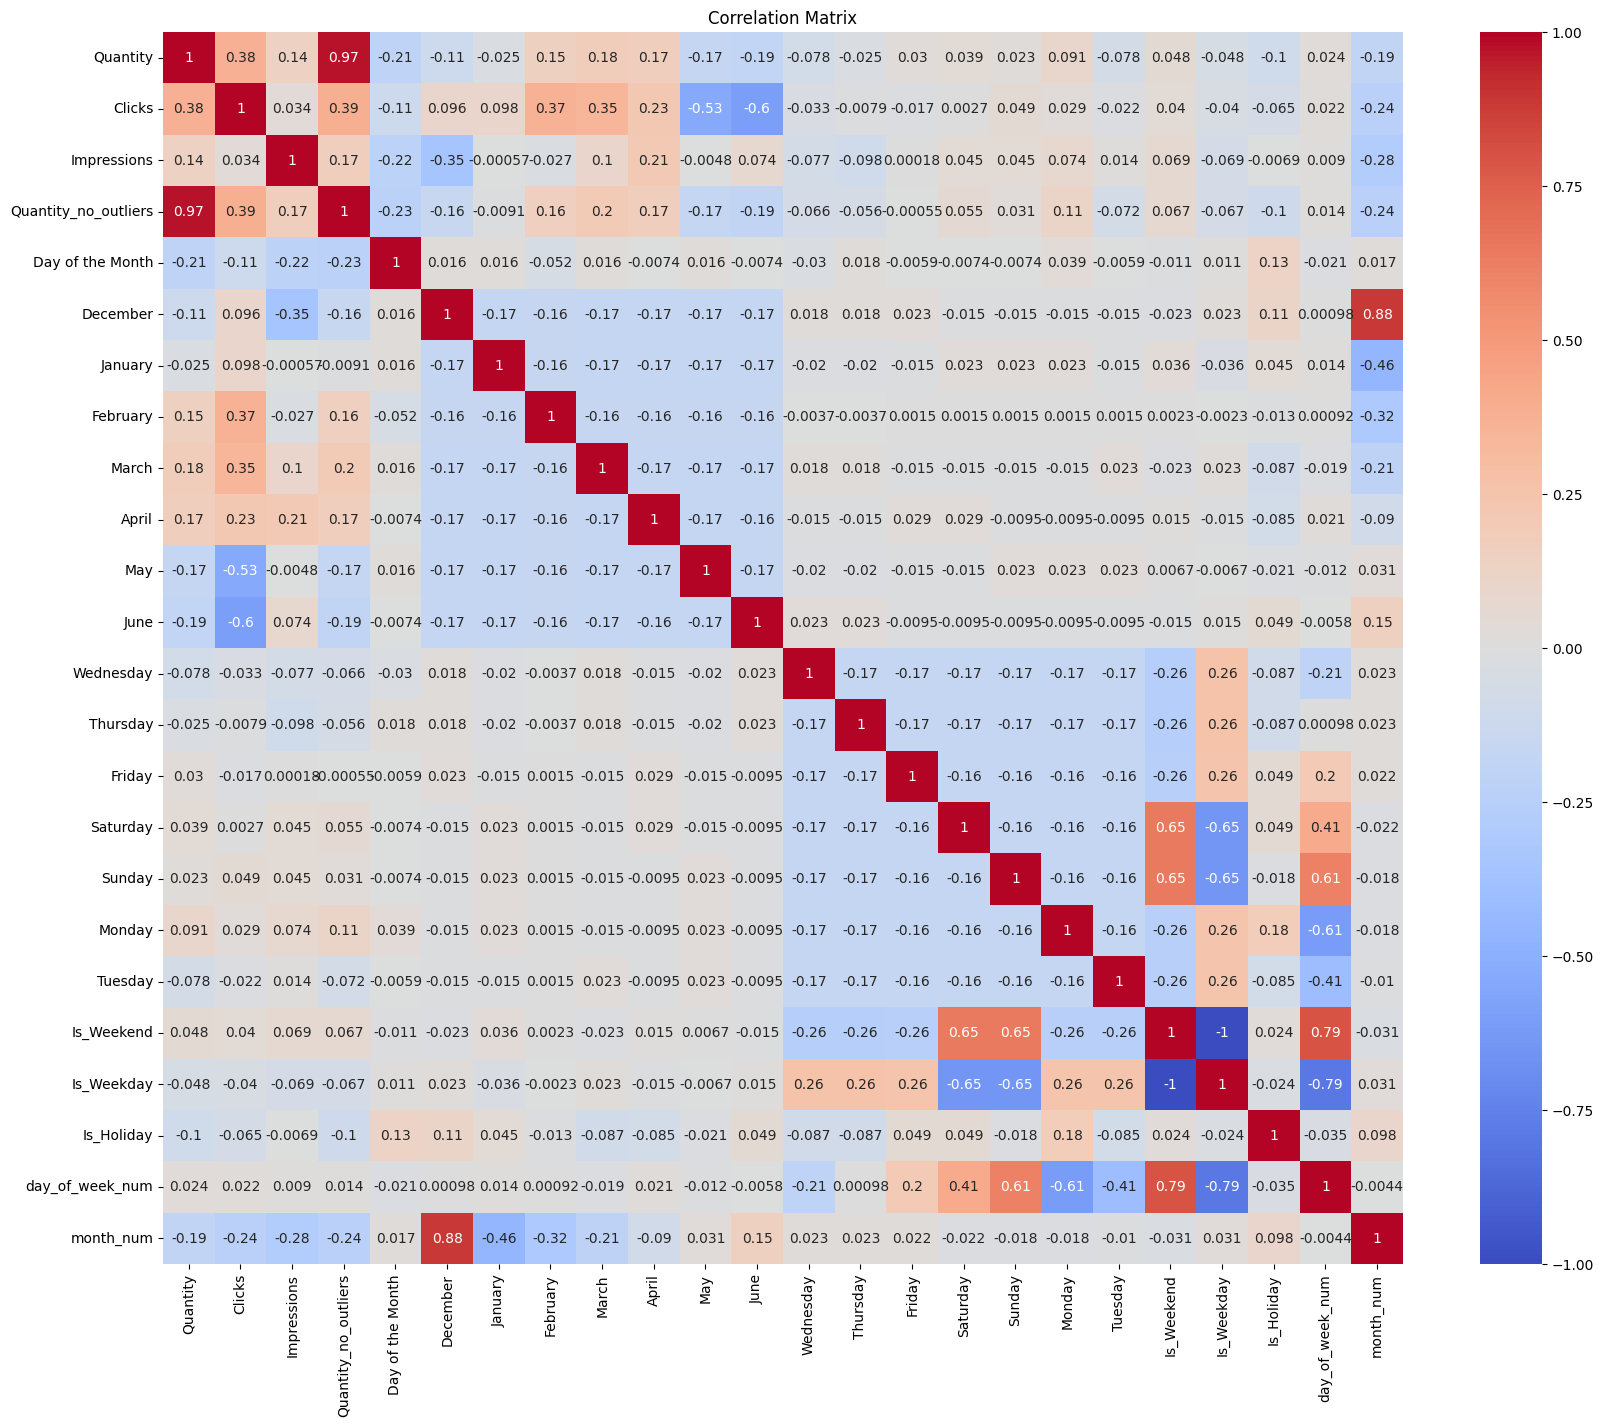

In [21]:
#Coorelation matrix

df_numeric = data.drop(columns=['Day Index', 'day_of_week', 'month'])

plt.figure(figsize=(20,16))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [22]:
# Setting the style of the visualizations
sns.set(style="whitegrid")

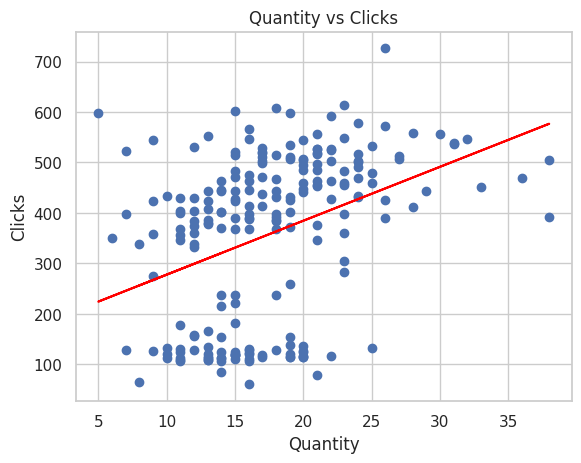

Slope: 10.684347244567512


In [23]:
# Clicks Effect on Quantity

x = df['Quantity'].values.reshape(-1, 1)
y = df['Clicks'].values

# Creating a linear regression model
model = LinearRegression()

# Fitting the model to the data
model.fit(x, y)

y_pred = model.predict(x)

# Plotting the data and the regression line
plt.scatter(x, y)
plt.plot(x, y_pred, color='red')
plt.xlabel('Quantity')
plt.ylabel('Clicks')
plt.title('Quantity vs Clicks')
plt.show()

slope = model.coef_[0]

print("Slope:", slope)

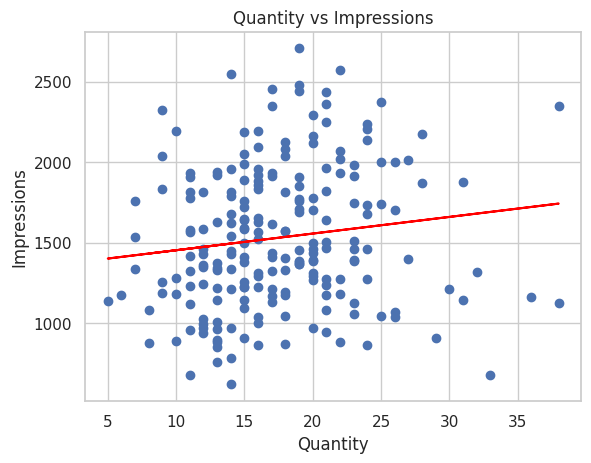

Slope: 10.345459685468713


In [24]:
# Impressions Effect on Quantity
x = df['Quantity'].values.reshape(-1, 1)
y = df['Impressions'].values

# Creating a linear regression model
model = LinearRegression()

# Fitting the model to the data
model.fit(x, y)

y_pred = model.predict(x)

# Plotting the data and the regression line
plt.scatter(x, y)
plt.plot(x, y_pred, color='red')
plt.xlabel('Quantity')
plt.ylabel('Impressions')
plt.title('Quantity vs Impressions')
plt.show()

slope = model.coef_[0]

print("Slope:", slope)


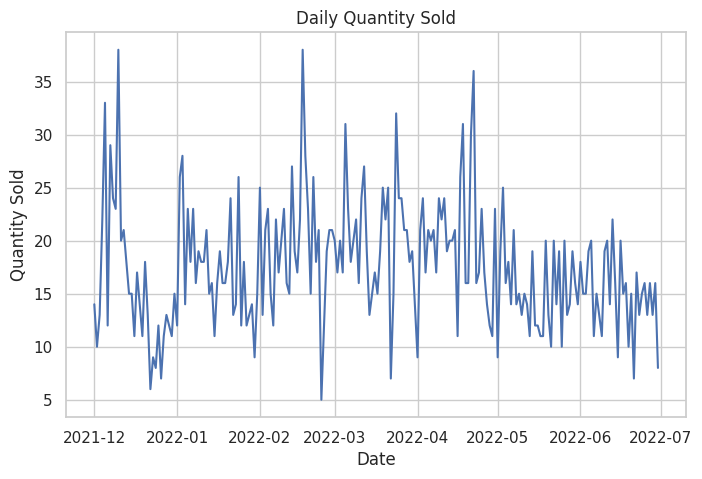

In [25]:
# Daily Quantity Sold
plt.figure(figsize=(8,5))
plt.plot(df['Day Index'], df['Quantity'])
plt.title('Daily Quantity Sold')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.show()


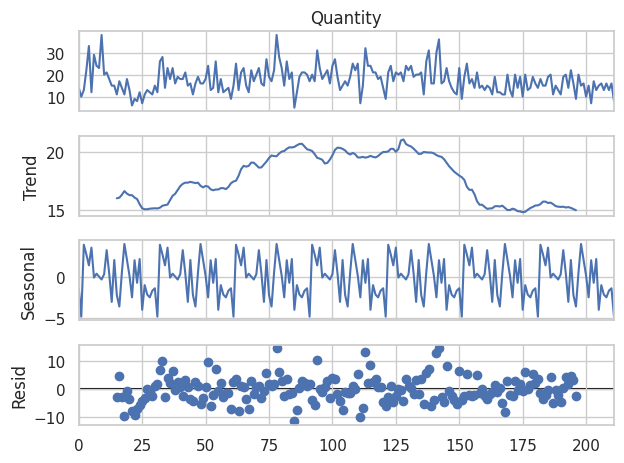

In [26]:
# Seasonality Test
decomposition = seasonal_decompose(df['Quantity'], model='additive', period=30)
decomposition.plot()
plt.show()

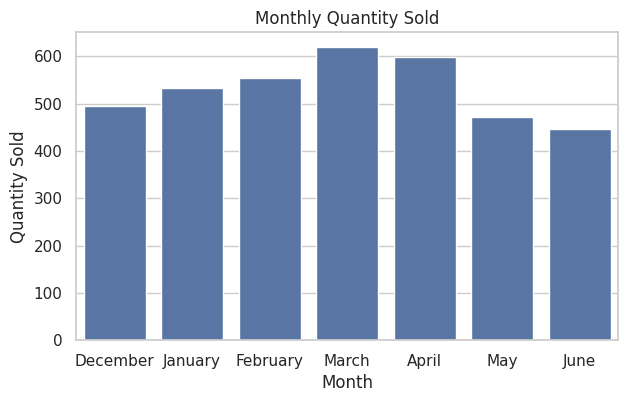

In [27]:
# Monthly Quantity Sold
monthly_quantity = df.groupby('month')['Quantity'].sum().reset_index()

plt.figure(figsize=(7,4))
sns.barplot(x='month', y='Quantity', data=monthly_quantity, order=['December','January', 'February', 'March', 'April', 'May', 'June'])
plt.title('Monthly Quantity Sold')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.show()


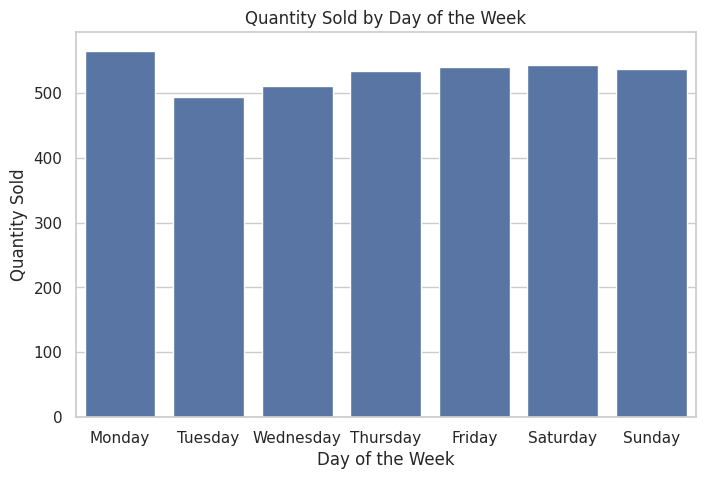

In [28]:
# Quantity Sold by Day of the Week
day_of_week_quantity = df.groupby('day_of_week')['Quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x='day_of_week', y='Quantity', data=day_of_week_quantity, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Quantity Sold by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Quantity Sold')
plt.show()


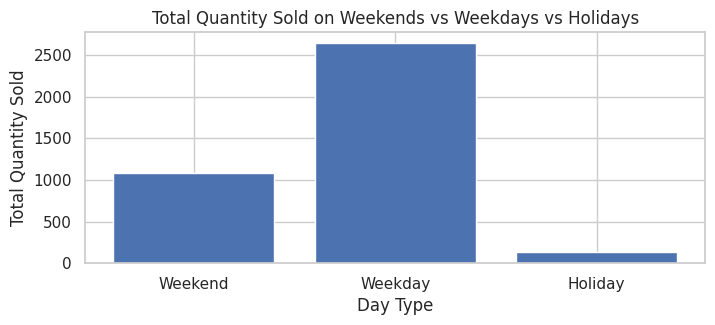

In [29]:
# Grouping data by weekend/weekday and calculate total quantity sold
weekend_sales = df[df['Is_Weekend'] == 1]['Quantity'].sum()
weekday_sales = df[df['Is_Weekday'] == 1]['Quantity'].sum()
holiday_sales = df[df['Is_Holiday'] == 1]['Quantity'].sum()

# Creating a bar plot
plt.figure(figsize=(8, 3))
plt.bar(['Weekend', 'Weekday', 'Holiday'], [weekend_sales, weekday_sales, holiday_sales])
plt.title('Total Quantity Sold on Weekends vs Weekdays vs Holidays')
plt.xlabel('Day Type')
plt.ylabel('Total Quantity Sold')
plt.show()

# **Analysis Report**

Values close to 1 indicate a strong positive correlation. Values close to -1 indicate a strong negative correlation. Values close to 0 indicate little to no correlation.

<> There is a strong positive correlation (0.38) between Quantity and Clicks. This means that as the quantity increases, the number of clicks also tends to increase.

<> Impressions also have slight relation to Quantity.

<> There seem to be recurring patterns or cycles in the sales data, which indicates seasonality.

<> March month  has the highest and June has the lowest sold quantity.

<> Monday has the highest and Tuesday has the lowest sale.


# **Time Series Analysis**


**Stationarity Test(Augmented Dickey–Fuller Test)**

In [30]:
# ADF Test for Sales Quantity
adf_result = adfuller(df['Quantity'])
print('ADF Statistic for Quantity:', adf_result[0].round(3))
print('p-value:', adf_result[1].round(4))

if adf_result[1] < 0.05:
    print("Sales quantity data is stationary.")
else:
    print("Sales quantity data is non-stationary.")


ADF Statistic for Quantity: -4.446
p-value: 0.0002
Sales quantity data is stationary.


**Autocorrelation and Partial Autocorrelation Function**

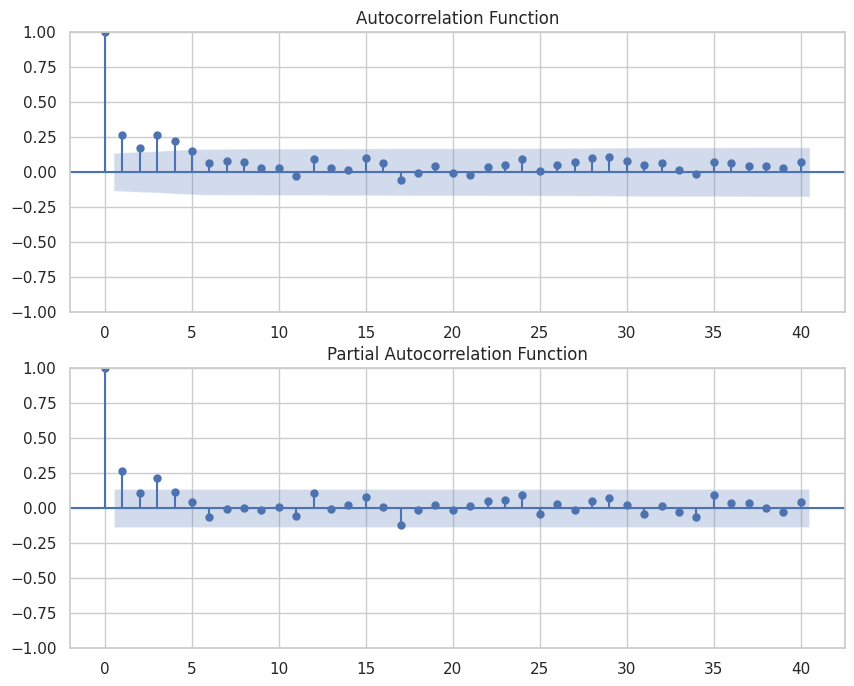

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))

# ACF plot
plot_acf(merged_data['Quantity'], ax=ax[0], lags=40)
ax[0].set_title('Autocorrelation Function')

# PACF plot
plot_pacf(merged_data['Quantity'], ax=ax[1], lags=40)
ax[1].set_title('Partial Autocorrelation Function')

plt.show()

# **Determined parameters**

Value of D is 0, as sales data quantity is stationary

Values of P and Q are 1, because the PACF plot cuts off after lag 1 and the ACF plot shows a significant spike at lag 1, followed by smaller spikes that die off quickly

# **Models**

In [32]:
# Splitting data into train, test, and validation sets
train_size = int(len(df) * 0.8)
test_size = int(len(df) * 0.1)

train = df[:train_size]
test = df[train_size:train_size + test_size]
val = df[train_size + test_size:]

print("Train size:", len(train))
print("Test size:", len(test))
print("Validation size:", len(val))

Train size: 169
Test size: 21
Validation size: 22


In [33]:
#function for ar,ma,arima and sarima model evaluation

def evaluate_model(train, val, test, model, model_name):

    feature = 'Quantity'
    feature_num = len(train.columns) - 1  #excluding the dependent variable ('Quantity')

    start_train = 0
    end_train = len(train) - 1
    start_val = len(train)
    end_val = start_val + len(val) - 1
    start_test = len(train) + len(val)
    end_test = start_test + len(test) - 1

    predictions_train = model.predict(start=start_train, end=end_train)
    predictions_val = model.predict(start=start_val, end=end_val)
    predictions_test = model.predict(start=start_test, end=end_test)

    def calculate_mape(actual_values, predicted_values):
        actual_values = np.array(actual_values)
        predicted_values = np.array(predicted_values)
        abs_percentage_error = np.abs((actual_values - predicted_values) / actual_values)
        abs_percentage_error[np.isnan(abs_percentage_error)] = 0
        mape = np.mean(abs_percentage_error) * 100
        return mape

    # Function to calculate adjusted R² score
    def adjusted_r2_score(r2, n, p):
        return 1 - (1 - r2) * (n - 1) / (n - p - 1)

     # Calculating metrics
    def calculate_metrics(actual, predicted, num_features):
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mape = calculate_mape(actual, predicted)
        r2 = r2_score(actual, predicted)
        adj_r2 = adjusted_r2_score(r2, len(actual), num_features)
        return rmse.round(2), mae.round(2), mape.round(2), r2.round(2), adj_r2.round(2)

    rmse_val, mae_val, mape_val, r2_val, adj_r2_val = calculate_metrics(val[feature], predictions_val, feature_num)
    rmse_test, mae_test, mape_test, r2_test, adj_r2_test = calculate_metrics(test[feature], predictions_test, feature_num)

    # Plotting predictions vs actuals for training, validation, and test sets
    plt.figure(figsize=(10,5))
    plt.plot(train.index, train['Quantity'], label='Training Data')
    plt.plot(val.index, val['Quantity'], label='Validation Data')
    plt.plot(test.index, test['Quantity'], label='Test Data')
    plt.plot(train.index, predictions_train, label='Training Predictions')
    plt.plot(val.index, predictions_val, label='Validation Predictions')
    plt.plot(test.index, predictions_test, label='Test Predictions')
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()

    # Printing metrics
    print(f'{model_name} Validation Set Metrics:')
    print(f'RMSE: \t\t{rmse_val}')
    print(f'MAE: \t\t{mae_val}')
    print(f'MAPE: \t\t{mape_val}%')
    print(f'R2: \t\t{r2_val}')
    print(f'Adjusted R2: \t{adj_r2_val}')

    print(f'\n{model_name} Test Set Metrics:')
    print(f'RMSE: \t\t{rmse_test}')
    print(f'MAE: \t\t{mae_test}')
    print(f'MAPE: \t\t{mape_test}%')
    print(f'R2: \t\t{r2_test}')
    print(f'Adjusted R2: \t{adj_r2_test}')

    return {
        'test' : {
            'rmse' : rmse_test,
            'mae' : mae_test,
            'mape' : mape_test,
            'r2' : r2_test,
            'adj_r2' : adj_r2_test},
        'validation' : {
            'rmse' : rmse_val,
            'mae' : mae_val,
            'mape' : mape_val,
            'r2' : r2_val,
            'adj_r2' : adj_r2_val}
    }

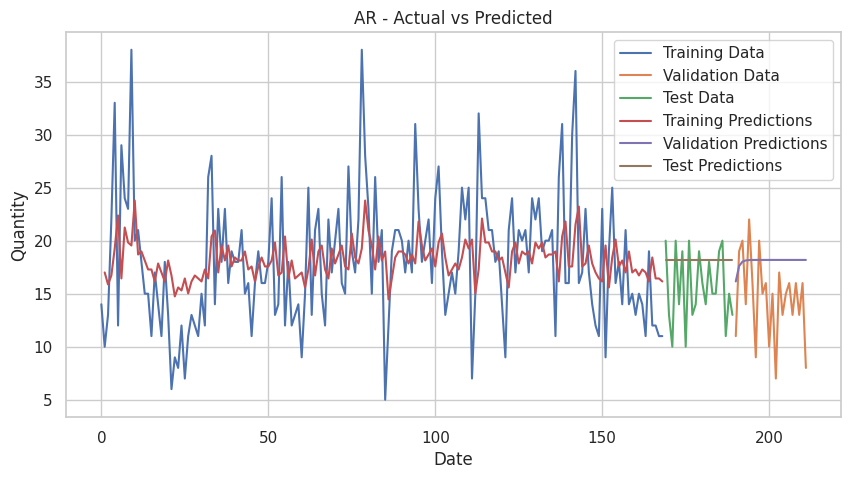

AR Validation Set Metrics:
RMSE: 		5.15
MAE: 		4.28
MAPE: 		38.61%
R2: 		-0.81
Adjusted R2: 	8.58

AR Test Set Metrics:
RMSE: 		4.19
MAE: 		3.49
MAPE: 		26.94%
R2: 		-0.6
Adjusted R2: 	6.33


In [34]:
# AR model
AR_model = AutoReg(train['Quantity'], lags=1).fit()
ar_results = evaluate_model(train, val, test, AR_model, model_name='AR')

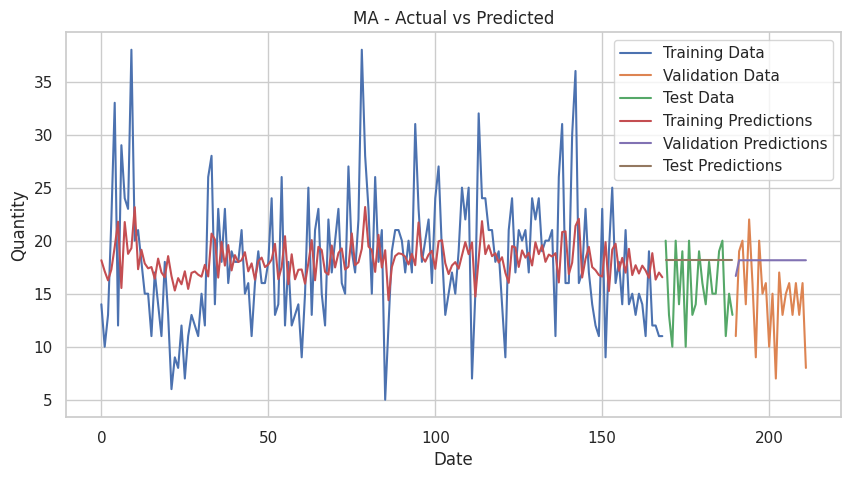

MA Validation Set Metrics:
RMSE: 		5.15
MAE: 		4.26
MAPE: 		38.51%
R2: 		-0.8
Adjusted R2: 	8.58

MA Test Set Metrics:
RMSE: 		4.17
MAE: 		3.48
MAPE: 		26.84%
R2: 		-0.58
Adjusted R2: 	6.28


In [35]:
# MA model
MA_model = ARIMA(train['Quantity'], order=(0, 0, 1)).fit()
ma_results = evaluate_model(train, val, test, MA_model, model_name='MA')

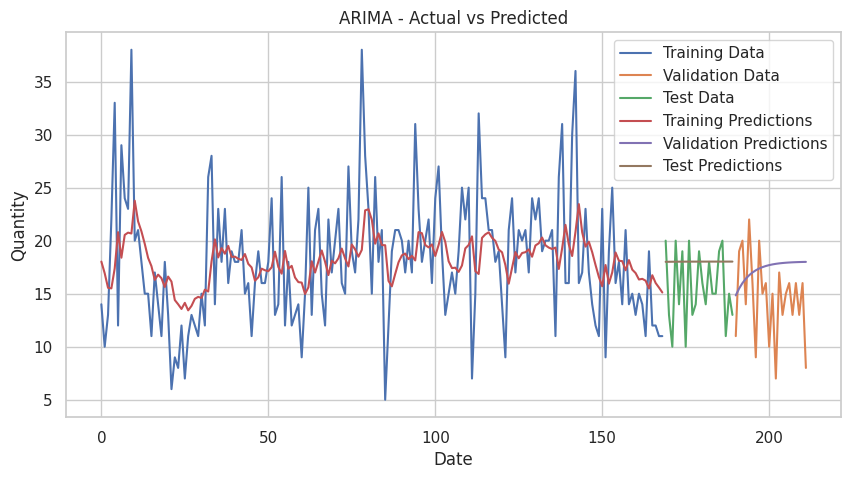

ARIMA Validation Set Metrics:
RMSE: 		4.95
MAE: 		4.13
MAPE: 		36.47%
R2: 		-0.67
Adjusted R2: 	8.0

ARIMA Test Set Metrics:
RMSE: 		4.1
MAE: 		3.44
MAPE: 		26.41%
R2: 		-0.52
Adjusted R2: 	6.08


In [36]:
# ARIMA model
ARIMA_model = ARIMA(train['Quantity'], order=(1, 0, 1)).fit()
arima_results = evaluate_model(train, val, test, ARIMA_model, model_name='ARIMA')

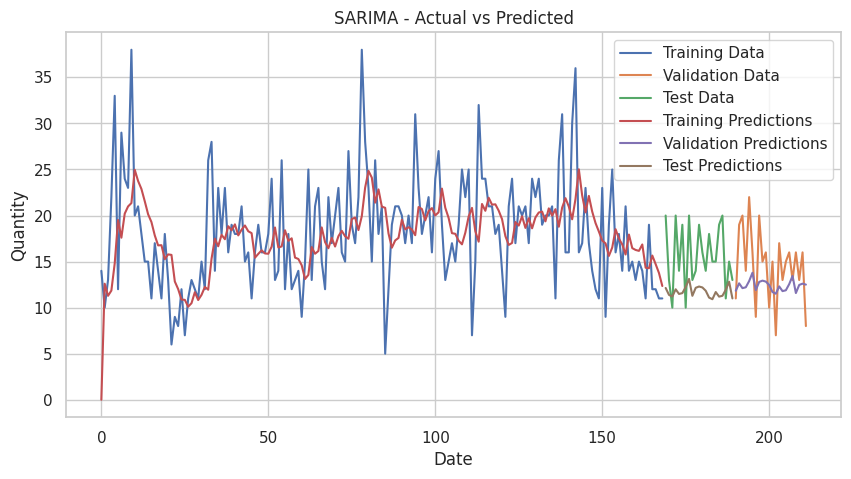

SARIMA Validation Set Metrics:
RMSE: 		4.28
MAE: 		3.62
MAPE: 		25.15%
R2: 		-0.25
Adjusted R2: 	6.24

SARIMA Test Set Metrics:
RMSE: 		5.05
MAE: 		4.28
MAPE: 		25.21%
R2: 		-1.32
Adjusted R2: 	8.74


In [37]:
# SARIMA model
sarima_model = SARIMAX(train['Quantity'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12)).fit()
sarima_results = evaluate_model(train, val, test, sarima_model, model_name='SARIMA')

In [38]:
#function to evaluate arimax and sarimax model

def evaluate_model_exog(train, val, test, exog_val, exog_test, model, model_name):

    feature_num = exog_val.shape[1]
    feature = 'Quantity'

    predictions_val = model.get_forecast(steps=len(val), exog=exog_val).predicted_mean
    predictions_test = model.get_forecast(steps=len(test), exog=exog_test).predicted_mean

    def calculate_mape(actual_values, predicted_values):
        actual_values = np.array(actual_values)
        predicted_values = np.array(predicted_values)
        abs_percentage_error = np.abs((actual_values - predicted_values) / actual_values)
        abs_percentage_error[np.isnan(abs_percentage_error)] = 0
        mape = np.mean(abs_percentage_error) * 100
        return mape

    # Function to calculate adjusted R² score
    def adjusted_r2_score(r2, n, p):
        return 1 - (1 - r2) * (n - 1) / (n - p - 1)

     # Calculating metrics
    def calculate_metrics(actual, predicted, num_features):
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mape = calculate_mape(actual, predicted)
        r2 = r2_score(actual, predicted)
        adj_r2 = adjusted_r2_score(r2, len(actual), num_features)
        return rmse.round(2), mae.round(2), mape.round(2), r2.round(2), adj_r2.round(2)

    rmse_val, mae_val, mape_val, r2_val, adj_r2_val = calculate_metrics(val[feature], predictions_val, feature_num)
    rmse_test, mae_test, mape_test, r2_test, adj_r2_test = calculate_metrics(test[feature], predictions_test, feature_num)

    # Plotting the results
    plt.figure(figsize=(10,5))
    plt.plot(train.index, train[feature], label='Train')
    plt.plot(val.index, val[feature], label='Validation')
    plt.plot(test.index, test[feature], label='Test')
    plt.plot(val.index, predictions_val, label='Validation Predictions')
    plt.plot(test.index, predictions_test, label='Test Predictions')
    plt.legend()
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.show()

    # Printing metrics
    print(f'{model_name} Validation Set Metrics:')
    print(f'RMSE: \t\t{rmse_val}')
    print(f'MAE: \t\t{mae_val}')
    print(f'MAPE: \t\t{mape_val}%')
    print(f'R2: \t\t{r2_val}')
    print(f'Adjusted R2: \t{adj_r2_val}')

    print(f'\n{model_name} Test Set Metrics:')
    print(f'RMSE: \t\t{rmse_test}')
    print(f'MAE: \t\t{mae_test}')
    print(f'MAPE: \t\t{mape_test}%')
    print(f'R2: \t\t{r2_test}')
    print(f'Adjusted R2: \t{adj_r2_test}')

    return {
        'test' : {
            'rmse' : rmse_test,
            'mae' : mae_test,
            'mape' : mape_test,
            'r2' : r2_test,
            'adj_r2' : adj_r2_test},
        'validation' : {
            'rmse' : rmse_val,
            'mae' : mae_val,
            'mape' : mape_val,
            'r2' : r2_val,
            'adj_r2' : adj_r2_val}
    }

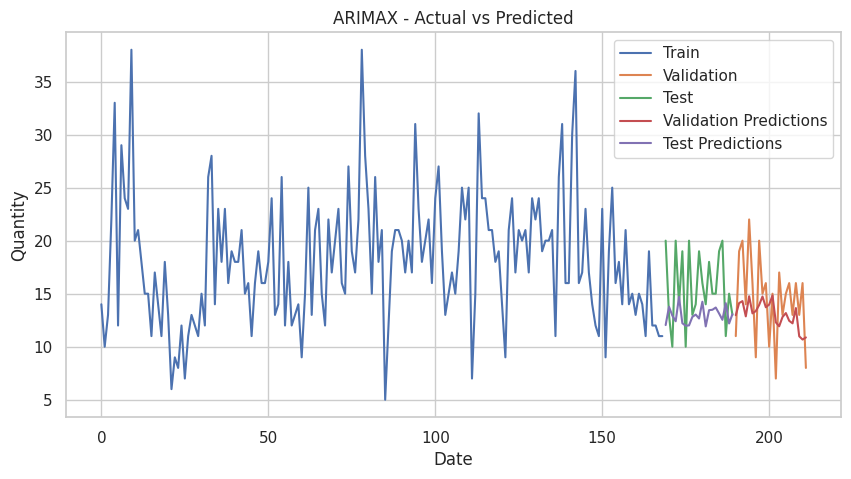

ARIMAX Validation Set Metrics:
RMSE: 		3.79
MAE: 		3.19
MAPE: 		23.35%
R2: 		0.02
Adjusted R2: 	-0.71

ARIMAX Test Set Metrics:
RMSE: 		4.5
MAE: 		3.56
MAPE: 		21.0%
R2: 		-0.84
Adjusted R2: 	-2.35


In [39]:
# Selecting exogenous variables
features = ['Clicks','Impressions','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

exog_train = train[features]
exog_val = val[features]
exog_test = test[features]

# ARIMAX model
arimax_model = SARIMAX(train['Quantity'], exog=exog_train, order=(1, 0, 1)).fit()
arimax_results = evaluate_model_exog(train, val, test, exog_val, exog_test, arimax_model, 'ARIMAX')

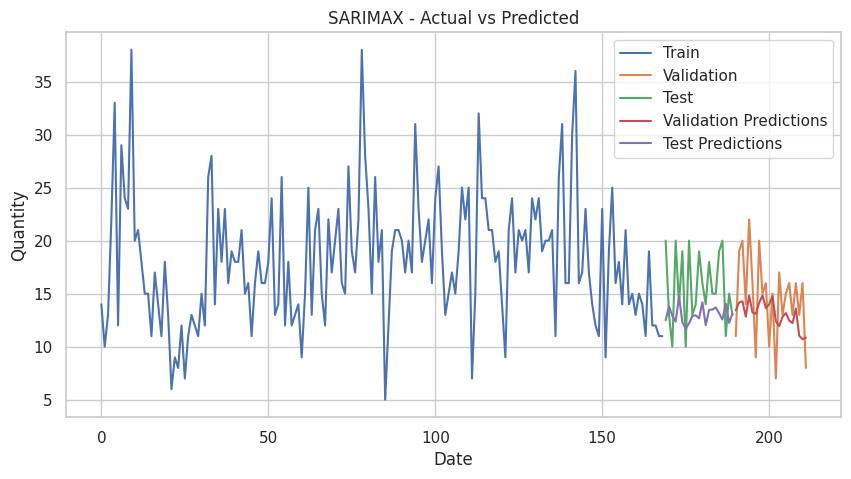

SARIMAX Validation Set Metrics:
RMSE: 		3.77
MAE: 		3.19
MAPE: 		23.38%
R2: 		0.03
Adjusted R2: 	-0.69

SARIMAX Test Set Metrics:
RMSE: 		4.43
MAE: 		3.51
MAPE: 		20.64%
R2: 		-0.78
Adjusted R2: 	-2.24


In [40]:
# SARIMAX model
sarimax_model = SARIMAX(train['Quantity'], exog=exog_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12)).fit()
sarimax_results = evaluate_model_exog(train, val, test, exog_val, exog_test, sarimax_model, 'SARIMAX')

In [41]:
#function for multivariate linear regression model

def model_multivariate(train, val, test, features, model, model_name='Model'):

    # Independent variables
    X_val = val[features]
    X_test = test[features]

    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)

    def calculate_mape(actual_values, predicted_values):
        actual_values = np.array(actual_values)
        predicted_values = np.array(predicted_values)
        abs_percentage_error = np.abs((actual_values - predicted_values) / actual_values)
        abs_percentage_error[np.isnan(abs_percentage_error)] = 0
        mape = np.mean(abs_percentage_error) * 100
        return mape

    # Function to calculate adjusted R² score
    def adjusted_r2_score(r2, n, p):
        return 1 - (1 - r2) * (n - 1) / (n - p - 1)

     # Calculating metrics
    def calculate_metrics(actual, predicted, num_features):
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mape = calculate_mape(actual, predicted)
        r2 = r2_score(actual, predicted)
        adj_r2 = adjusted_r2_score(r2, len(actual), num_features)
        return rmse.round(2), mae.round(2), mape.round(2), r2.round(2), adj_r2.round(2)

    rmse_val, mae_val, mape_val, r2_val, adj_r2_val= calculate_metrics(val['Quantity'], val_pred, X_val.shape[1])
    rmse_test, mae_test, mape_test, r2_test, adj_r2_test= calculate_metrics(test['Quantity'], test_pred, X_test.shape[1])

    # Plotting predictions vs actuals for all sets
    plt.figure(figsize=(10,5))
    plt.plot(train.index, train['Quantity'], label='Training Actual')
    plt.plot(val.index, val['Quantity'], label='Validation Actual')
    plt.plot(test.index, test['Quantity'], label='Test Actual')
    plt.plot(val.index, val_pred, label='Validation Predicted')
    plt.plot(test.index, test_pred, label='Test Predicted')
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.xlabel('Index')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()

    # Printing metrics
    print(f'{model_name} Validation Set Metrics:')
    print(f'RMSE: \t\t{rmse_val}')
    print(f'MAE: \t\t{mae_val}')
    print(f'MAPE: \t\t{mape_val}%')
    print(f'R2: \t\t{r2_val}')
    print(f'Adjusted R2: \t{adj_r2_val}')

    print(f'\n{model_name} Test Set Metrics:')
    print(f'RMSE: \t\t{rmse_test}')
    print(f'MAE: \t\t{mae_test}')
    print(f'MAPE: \t\t{mape_test}%')
    print(f'R2: \t\t{r2_test}')
    print(f'Adjusted R2: \t{adj_r2_test}')

    return {
        'test' : {
            'rmse' : rmse_test,
            'mae' : mae_test,
            'mape' : mape_test,
            'r2' : r2_test,
            'adj_r2' : adj_r2_test},
        'validation' : {
            'rmse' : rmse_val,
            'mae' : mae_val,
            'mape' : mape_val,
            'r2' : r2_val,
            'adj_r2' : adj_r2_val}
    }

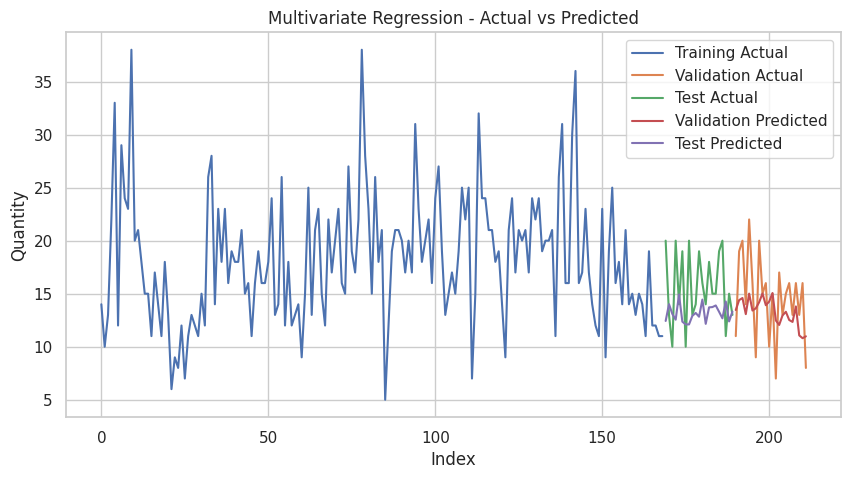

Multivariate Regression Validation Set Metrics:
RMSE: 		3.72
MAE: 		3.11
MAPE: 		23.14%
R2: 		0.06
Adjusted R2: 	-0.65

Multivariate Regression Test Set Metrics:
RMSE: 		4.39
MAE: 		3.48
MAPE: 		20.65%
R2: 		-0.75
Adjusted R2: 	-2.19


In [42]:
# features
features = ['Clicks','Impressions','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Dependent and independent variables
y_train = train['Quantity']
X_train = train[features]

# Training the model
model = LinearRegression()
model.fit(X_train, y_train)

lr_results = model_multivariate(train, val, test, features, model, 'Multivariate Regression')

In [43]:
#comparing results
test_results = {
        'Model': ['AR', 'MA', 'ARIMA', 'SARIMA', 'ARIMAX', 'SARIMAX', 'Multivariate Linear Regression'],
        'MAE': [ar_results['test']['mae'], ma_results['test']['mae'], arima_results['test']['mae'],sarima_results['test']['mae'], arimax_results['test']['mae'], sarimax_results['test']['mae'], lr_results['test']['mae']],
        'RMSE': [ar_results['test']['rmse'], ma_results['test']['rmse'], arima_results['test']['rmse'],sarima_results['test']['rmse'], arimax_results['test']['rmse'], sarimax_results['test']['rmse'], lr_results['test']['rmse']],
        'MAPE': [ar_results['test']['mape'], ma_results['test']['mape'], arima_results['test']['mape'],sarima_results['test']['mape'], arimax_results['test']['mape'], sarimax_results['test']['mape'], lr_results['test']['mape']],
        'R^2': [ar_results['test']['r2'], ma_results['test']['r2'], arima_results['test']['r2'],sarima_results['test']['r2'], arimax_results['test']['r2'], sarimax_results['test']['r2'], lr_results['test']['r2']],
        'Adj R^2': [ar_results['test']['adj_r2'], ma_results['test']['adj_r2'], arima_results['test']['adj_r2'],sarima_results['test']['adj_r2'], arimax_results['test']['adj_r2'], sarimax_results['test']['adj_r2'], lr_results['test']['adj_r2']],
}

validation_results = {
        'Model': ['AR', 'MA', 'ARIMA', 'SARIMA', 'ARIMAX', 'SARIMAX', 'Multivariate Linear Regression'],
        'MAE': [ar_results['validation']['mae'], ma_results['validation']['mae'], arima_results['validation']['mae'],sarima_results['validation']['mae'], arimax_results['validation']['mae'], sarimax_results['validation']['mae'], lr_results['validation']['mae']],
        'RMSE': [ar_results['validation']['rmse'], ma_results['validation']['rmse'], arima_results['validation']['rmse'],sarima_results['validation']['rmse'], arimax_results['validation']['rmse'], sarimax_results['validation']['rmse'], lr_results['validation']['rmse']],
        'MAPE': [ar_results['validation']['mape'], ma_results['validation']['mape'], arima_results['validation']['mape'],sarima_results['validation']['mape'], arimax_results['validation']['mape'], sarimax_results['validation']['mape'], lr_results['validation']['mape']],
        'R^2': [ar_results['validation']['r2'], ma_results['validation']['r2'], arima_results['validation']['r2'],sarima_results['validation']['r2'], arimax_results['validation']['r2'], sarimax_results['validation']['r2'], lr_results['validation']['r2']],
        'Adj R^2': [ar_results['validation']['adj_r2'], ma_results['validation']['adj_r2'], arima_results['validation']['adj_r2'],sarima_results['validation']['adj_r2'], arimax_results['validation']['adj_r2'], sarimax_results['validation']['adj_r2'], lr_results['validation']['adj_r2']]
    }

# Creating DataFrames
test_df = pd.DataFrame(test_results)
validation_df = pd.DataFrame(validation_results)

# Printing the test results
print("Test Results:")
print(test_df)

# Printing the validation results
print("\nValidation Results:")
print(validation_df)

Test Results:
                            Model   MAE  RMSE   MAPE   R^2  Adj R^2
0                              AR  3.49  4.19  26.94 -0.60     6.33
1                              MA  3.48  4.17  26.84 -0.58     6.28
2                           ARIMA  3.44  4.10  26.41 -0.52     6.08
3                          SARIMA  4.28  5.05  25.21 -1.32     8.74
4                          ARIMAX  3.56  4.50  21.00 -0.84    -2.35
5                         SARIMAX  3.51  4.43  20.64 -0.78    -2.24
6  Multivariate Linear Regression  3.48  4.39  20.65 -0.75    -2.19

Validation Results:
                            Model   MAE  RMSE   MAPE   R^2  Adj R^2
0                              AR  4.28  5.15  38.61 -0.81     8.58
1                              MA  4.26  5.15  38.51 -0.80     8.58
2                           ARIMA  4.13  4.95  36.47 -0.67     8.00
3                          SARIMA  3.62  4.28  25.15 -0.25     6.24
4                          ARIMAX  3.19  3.79  23.35  0.02    -0.71
5            

Based on the test and validation results, the **Multivariate Linear Regression** model appears to be the best choice for demand forecasting. The model demonstrates the MAE (3.11) and RMSE (3.72) on the validation set, as well as the lowest MAPE (23.14%).

The group of features used in the model : 'Clicks', 'Impressions', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'.